In [17]:
import yaml
import numpy as np
import pandas
import torch
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from torch import nn
import math
import matplotlib.pyplot as plt

EPOCHS = 20
BATCH_SIZE = 50
LR = 0.1
WEIGHT_DECAY = 0.08
# RANDOM_SEED = 42


In [11]:
# load in x_train (augmented 0->199)
with open("aug_data.yaml", "r") as f:
    data_dict = yaml.load(f, Loader=yaml.CBaseLoader)
    x_train = np.asarray(list(data_dict.values()))

# load in y_train (augmented 0->199)
with open("aug_data_label.yaml", "r") as f:
    data_dict = yaml.load(f, Loader=yaml.CBaseLoader)
    y_train = np.asarray(list(data_dict.values()))

# load in x_test (original 200->)
with open("test_data_for_aug.yaml", "r") as f:
    data_dict = yaml.load(f, Loader=yaml.CBaseLoader)
    x_test = np.asarray(list(data_dict.values()))

# load in y_test (original 200->)
with open("test_label_for_aug.yaml", "r") as f:
    data_dict = yaml.load(f, Loader=yaml.CBaseLoader)
    y_test = np.asarray(list(data_dict.values()))


num_of_features = x_train.shape[1]

In [12]:
train_data = torch.from_numpy(x_train.astype(np.float32))
test_data = torch.from_numpy(x_test.astype(np.float32))
train_label = torch.from_numpy(y_train.astype(np.float32)).type(torch.LongTensor)
test_label = torch.from_numpy(y_test.astype(np.float32)).type(torch.LongTensor)

In [13]:
train_data.size()[0]


372

In [20]:
# setup neural network and optimizer&loss
features = 20
module = nn.Sequential(
    nn.Linear(in_features=num_of_features, out_features=features),
    nn.ReLU(),
    # nn.Dropout(p=0.2),
    nn.Linear(in_features=features, out_features=features),
    nn.LeakyReLU(),
    nn.Linear(in_features=features, out_features=10)
)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=module.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


In [21]:
def acc_func( pred:torch.Tensor, true_label:torch.Tensor) -> float:
    pred_labels = torch.softmax(pred, dim=1).argmax(dim=1)
    return sum(pred_labels == true_label) / len(true_label)

# training
epochs = EPOCHS
batch_size = BATCH_SIZE

train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in tqdm(range(epochs)):
    print(f"----------------------epoch{epoch} --------------------")
    data_index = 0
    for batch_number in range(math.ceil(train_data.size()[0] / batch_size)):
        # if batch_number % 10 == 0:
        #     print(f"batch#{batch_number}/{math.ceil(train_data.size()[0] / batch_size)}")
        this_batch_data = train_data[data_index:data_index+batch_size,:]
        this_batch_label = train_label[data_index:data_index+batch_size]
        data_index = data_index + batch_size
        # forward pass
        y_pred = module(this_batch_data)
        # get loss
        loss = loss_func(y_pred, this_batch_label)
        # zero grad
        optimizer.zero_grad()
        # loss back
        loss.backward()
        # step
        optimizer.step()

    # end of epoch, making prediction and store summary
    with torch.inference_mode():
        # train loss
        trainloss = loss_func(module(train_data), train_label)
        train_loss.append(trainloss)
        # train acc
        trainacc = acc_func(module(train_data), train_label)
        train_acc.append(trainacc)
        # test loss
        testloss = loss_func(module(test_data), test_label)
        test_loss.append(testloss)
        # test acc
        testacc = acc_func(module(test_data), test_label)
        test_acc.append(testacc)
        print(f"train loss:{trainloss:.2f} | "
              f"train acc:{trainacc*100:.2f}% | "
              f"test loss:{testloss:.2f} | "
              f"test acc:{testacc*100:.2f}%")



  0%|          | 0/20 [00:00<?, ?it/s]

----------------------epoch0 --------------------
train loss:1.91 | train acc:68.01% | test loss:2.16 | test acc:28.92%
----------------------epoch1 --------------------
train loss:1.34 | train acc:63.98% | test loss:2.01 | test acc:34.94%
----------------------epoch2 --------------------
train loss:0.93 | train acc:72.04% | test loss:1.95 | test acc:30.12%
----------------------epoch3 --------------------
train loss:0.70 | train acc:78.76% | test loss:1.95 | test acc:30.12%
----------------------epoch4 --------------------
train loss:0.58 | train acc:83.06% | test loss:1.97 | test acc:31.33%
----------------------epoch5 --------------------
train loss:0.48 | train acc:88.71% | test loss:2.00 | test acc:31.33%
----------------------epoch6 --------------------
train loss:0.41 | train acc:90.05% | test loss:2.02 | test acc:30.12%
----------------------epoch7 --------------------
train loss:0.35 | train acc:91.13% | test loss:2.04 | test acc:31.33%
----------------------epoch8 -----------

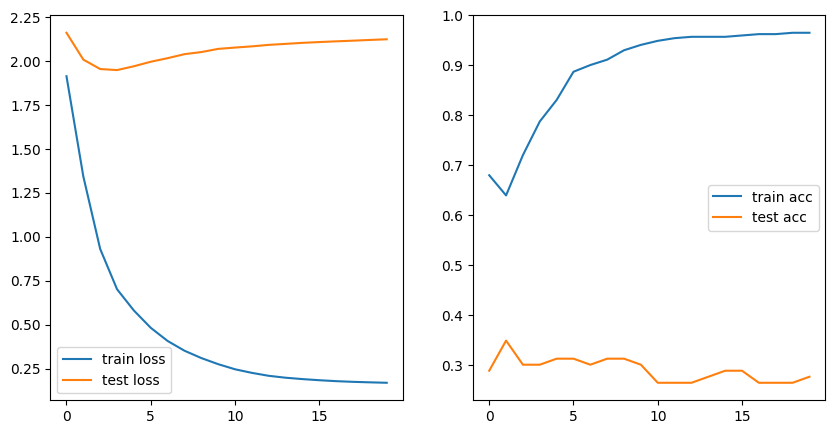

In [22]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(["train loss", "test loss"])
plt.subplot(1,2,2)
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(["train acc", "test acc"])
plt.show()